## Random Forest for the high-range price cars:

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
import shap
from sklearn.model_selection import KFold
import scipy.stats as stats

%matplotlib inline

In [75]:
#cleaned dataset
df = pd.read_csv("auto_data_cleaned_16_09_2024.csv")

df = df[(np.abs(stats.zscore(df['price_in_euro'])) >1)& (np.abs(stats.zscore(df['price_in_euro'])) <10)]  

# the models will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['model'])
df['Modell_encoded'] = target_encoder.fit_transform(df['model'], df['price_in_euro'])  # 'Preis' ist die Zielvariable


# the brand will be encoded by mean value of price of every model
target_encoder = ce.TargetEncoder(cols=['brand'])
df['Brand_encoded'] = target_encoder.fit_transform(df['brand'], df['price_in_euro'])  # 'Preis' ist die Zielvariable

df=df.drop(columns=['year' ])

df = pd.get_dummies(df, columns=[ 'fuel_type', 'transmission_type','color'], dtype='int')

# Remove outliers using Z-score for price and mileage
#df_clean = df[(np.abs(stats.zscore(df['price_in_euro'])) >1)& (np.abs(stats.zscore(df['price_in_euro'])) <10)]  # 7 is the higher threshold for outliers
#df_clean = df_clean[(np.abs(stats.zscore(df_clean['mileage_in_km'])) < 4)]  # Do the same for mileage



In [76]:
df['price_in_euro'].describe()

count     11389.000000
mean     113656.634296
std       64869.491076
min       62150.000000
25%       69990.000000
50%       85890.000000
75%      129911.000000
max      389700.000000
Name: price_in_euro, dtype: float64

In [77]:
# Splitting the data into training and test sets
X = df.drop(['price_in_euro', 'model', 'brand', 'offer_description'], axis=1)  # Features
y = df['price_in_euro']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [78]:
# Initialize the model with default parameters
rf = RandomForestRegressor(n_estimators=500, max_depth=20)
# Train the model
rf.fit(X_train, y_train)

#  Evaluate the model on the Test Set
y_pred = rf.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = mse_test ** 0.5

print(f"Test MAE - full dataset: {test_mae}")
print(f"Test Set MSE - full dataset: {mse_test}")
print(f"Test R² - full dataset: {test_r2}")
print(f"Test RMSE - full dataset: {rmse_test:.2f}")



Test MAE - full dataset: 12224.883987418538
Test Set MSE - full dataset: 435179319.35576385
Test R² - full dataset: 0.8997832445279621
Test RMSE - full dataset: 20860.95


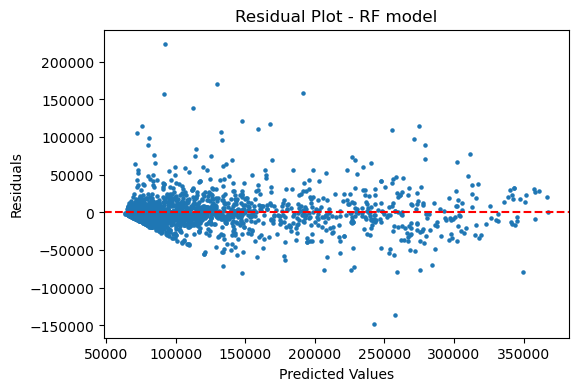

In [79]:
# Plot Residuals
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, s = 5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - RF model')
plt.show()

In [80]:
#  Now we will use the scaled version of Modell_encoded for the merge
# Prepare DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual Price': y_test,               
    'Predicted Price': y_pred,
    'Residuals': y_test-y_pred,
    'Abs_residuals':abs(y_test-y_pred),
    'Year' :2024 -  X_test['age'],
    'Power': X_test['power_ps'],
    'Mileage': X_test['mileage_in_km'],
    'Modell_encoded': X_test['Modell_encoded'],
    
})

# Step 3: Extract the original 'model' names from df_clean, including the scaled Modell_encoded
models_df = df[['Modell_encoded', 'model', 'brand', 'offer_description']].drop_duplicates()  # Ensure unique Modell_encoded_scaled values

# Step 4: Merge the comparison DataFrame with models_df based on 'Modell_encoded_scaled'
final_comparison_df = pd.merge(comparison_df, models_df, on='Modell_encoded', how='left')

# View the final comparison DataFrame
final_comparison_df


,Actual Price,Predicted Price,Residuals,Abs_residuals,Year,Power,Mileage,Modell_encoded,model,brand,offer_description
0,63100.0,67108.847512,-4008.847512,4008.847512,2021.0,185.0,27856.0,76014.823313,Ford Transit Custom,ford,2.0 Aut. Nugget Plus (AHK+Xenon)
1,63100.0,67108.847512,-4008.847512,4008.847512,2021.0,185.0,27856.0,76014.823313,Ford Transit Custom,ford,2.0 Aut. Nugget Plus (AHK+ACC)
2,63100.0,67108.847512,-4008.847512,4008.847512,2021.0,185.0,27856.0,76014.823313,Ford Transit Custom,ford,Nugget L1
3,63100.0,67108.847512,-4008.847512,4008.847512,2021.0,185.0,27856.0,76014.823313,Ford Transit Custom,ford,Nugget *Automatik *Aufstelldach*PDC*DAB*
4,63100.0,67108.847512,-4008.847512,4008.847512,2021.0,185.0,27856.0,76014.823313,Ford Transit Custom,ford,2.0 Aut. Nugget Plus (Solar+iACC)
...,...,...,...,...,...,...,...,...,...,...,...
256731,63775.0,67403.871066,-3628.871066,3628.871066,2018.0,450.0,56750.0,88008.541855,Audi RS4,audi,331(450) kW(PS) tiptronic
256732,63775.0,67403.871066,-3628.871066,3628.871066,2018.0,450.0,56750.0,88008.541855,Audi RS4,audi,tiptronic +LED+PDC+BANG&OLUFSEN
256733,63775.0,67403.871066,-3628.871066,3628.871066,2018.0,450.0,56750.0,88008.541855,Audi RS4,audi,"X Avant ABT tiptr. - B&O,HEAD-UP,MATRIX,NAVI"
256734,63775.0,67403.871066,-3628.871066,3628.871066,2018.0,450.0,56750.0,88008.541855,Audi RS4,audi,"X Avant ABT - NAVI,MATRIX,PANO,ACC,305 KM/H"


In [81]:
final_comparison_df.sort_values(by='Residuals').head(20)

,Actual Price,Predicted Price,Residuals,Abs_residuals,Year,Power,Mileage,Modell_encoded,model,brand,offer_description
112299,94500.0,242158.716333,-147658.716333,147658.716333,2020.0,521.0,3950.0,136961.623729,Porsche 911,porsche,(911) Targa 4 GTS | Interieur-Paket GTS |
112122,94500.0,242158.716333,-147658.716333,147658.716333,2020.0,521.0,3950.0,136961.623729,Porsche 911,porsche,Carrera 4S Cabrio 50 Jahre Porsche Scheckh
112121,94500.0,242158.716333,-147658.716333,147658.716333,2020.0,521.0,3950.0,136961.623729,Porsche 911,porsche,911 Carrera 4S Cabriolet PDK
112120,94500.0,242158.716333,-147658.716333,147658.716333,2020.0,521.0,3950.0,136961.623729,Porsche 911,porsche,Turbo (Sport Chrono-PDLS) APPROVED 1.Hand!
112298,94500.0,242158.716333,-147658.716333,147658.716333,2020.0,521.0,3950.0,136961.623729,Porsche 911,porsche,"GT4 PDK 718 Clubsport,Chrono,Bose,Carbon"
112118,94500.0,242158.716333,-147658.716333,147658.716333,2020.0,521.0,3950.0,136961.623729,Porsche 911,porsche,Turbo S Cabriolet 991 Sport-Chrono-Paket
112117,94500.0,242158.716333,-147658.716333,147658.716333,2020.0,521.0,3950.0,136961.623729,Porsche 911,porsche,Turbo S *9FF Komplettumbau*4.0L Motor*
112116,94500.0,242158.716333,-147658.716333,147658.716333,2020.0,521.0,3950.0,136961.623729,Porsche 911,porsche,"991 3,8 Turbo PDK Sport-Chrono/Ceramic/PDLS+/PDCC"
112115,94500.0,242158.716333,-147658.716333,147658.716333,2020.0,521.0,3950.0,136961.623729,Porsche 911,porsche,"Carrera PDK ""OPTIONSPAKET 50 Jahre 911"""
112114,94500.0,242158.716333,-147658.716333,147658.716333,2020.0,521.0,3950.0,136961.623729,Porsche 911,porsche,Carrera 4S Cabriolet PDK Bose


In [82]:
final_comparison_df.sort_values(by='Residuals').tail(20)

,Actual Price,Predicted Price,Residuals,Abs_residuals,Year,Power,Mileage,Modell_encoded,model,brand,offer_description
176348,299991.0,129745.842074,170245.157926,170245.157926,2020.0,420.0,892.0,97105.331882,Porsche 718,porsche,Boxster PDK
176361,299991.0,129745.842074,170245.157926,170245.157926,2020.0,420.0,892.0,97105.331882,Porsche 718,porsche,"Boxster T PDK, PASM, PDLS, Sport Chrono, Appr..."
176360,299991.0,129745.842074,170245.157926,170245.157926,2020.0,420.0,892.0,97105.331882,Porsche 718,porsche,Cayman GTS PDK 718 *DAB*APPROVED*20ZOLL
176359,299991.0,129745.842074,170245.157926,170245.157926,2020.0,420.0,892.0,97105.331882,Porsche 718,porsche,718 Boxster GTS PDK
176358,299991.0,129745.842074,170245.157926,170245.157926,2020.0,420.0,892.0,97105.331882,Porsche 718,porsche,Cayman GTS 2.5 *SPORTABGAS*PDLS+*BOSE*VOLL*
176357,299991.0,129745.842074,170245.157926,170245.157926,2020.0,420.0,892.0,97105.331882,Porsche 718,porsche,Boxster
176356,299991.0,129745.842074,170245.157926,170245.157926,2020.0,420.0,892.0,97105.331882,Porsche 718,porsche,Boxster GTS - SportDesign - Approved - PDK
48476,315890.0,91941.288570,223948.711430,223948.711430,2023.0,95.0,6000.0,111012.416378,Audi A1,audi,Sportback 25 TFSI advanced S-tronic Dynamik LE...
48470,315890.0,91941.288570,223948.711430,223948.711430,2023.0,95.0,6000.0,111012.416378,Audi A1,audi,A1 1.4 TFSI Sportback cylinder on demand S tronic
48475,315890.0,91941.288570,223948.711430,223948.711430,2023.0,95.0,6000.0,111012.416378,Audi A1,audi,Sportback 30 TFSI S line + Navi + LED + ACC


In [83]:
final_comparison_df.sort_values(by='Abs_residuals').head(20)

,Actual Price,Predicted Price,Residuals,Abs_residuals,Year,Power,Mileage,Modell_encoded,model,brand,offer_description
239491,67740.0,67740.644696,-0.644696,0.644696,2022.0,185.0,10.0,73023.120981,Ford Transit,ford,Big Nugget 185PS/Sicht-P3/Klima -18%*
239505,67740.0,67740.644696,-0.644696,0.644696,2022.0,185.0,10.0,73023.120981,Ford Transit,ford,Nugget /Aufstelldach 150PS Aut.
239504,67740.0,67740.644696,-0.644696,0.644696,2022.0,185.0,10.0,73023.120981,Ford Transit,ford,Nugget Plus/Aufstelldach 150PS -2%*
239503,67740.0,67740.644696,-0.644696,0.644696,2022.0,185.0,10.0,73023.120981,Ford Transit,ford,Nugget/HD 130PS/Sicht-P3 -13%*
239502,67740.0,67740.644696,-0.644696,0.644696,2022.0,185.0,10.0,73023.120981,Ford Transit,ford,Nugget Plus/Aufstelldach 130PS -3%*
239501,67740.0,67740.644696,-0.644696,0.644696,2022.0,185.0,10.0,73023.120981,Ford Transit,ford,Nugget Plus/Aufstelldach 150PS -3%*
239500,67740.0,67740.644696,-0.644696,0.644696,2022.0,185.0,10.0,73023.120981,Ford Transit,ford,Kasten 350 L3 Trend 2.0 TDCi DPF EU6d-T
239499,67740.0,67740.644696,-0.644696,0.644696,2022.0,185.0,10.0,73023.120981,Ford Transit,ford,E- Kasten 350 L3H2 Trend Aut. HA -16%*
239498,67740.0,67740.644696,-0.644696,0.644696,2022.0,185.0,10.0,73023.120981,Ford Transit,ford,Nugget Plus/AD 130PS Aut./Sicht-P
239506,67740.0,67740.644696,-0.644696,0.644696,2022.0,185.0,10.0,73023.120981,Ford Transit,ford,Nugget /Aufstelld. 150PS/Sicht-P3


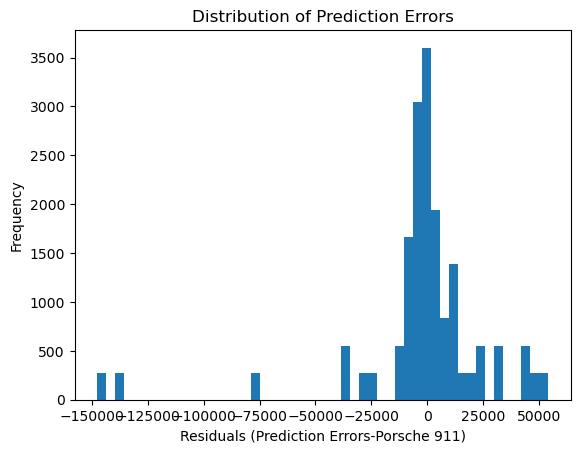

In [84]:
# Plot histogram of residuals
plt.hist(final_comparison_df['Residuals'].loc[final_comparison_df['model']=='Porsche 911'], bins=50)
plt.xlabel('Residuals (Prediction Errors-Porsche 911)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

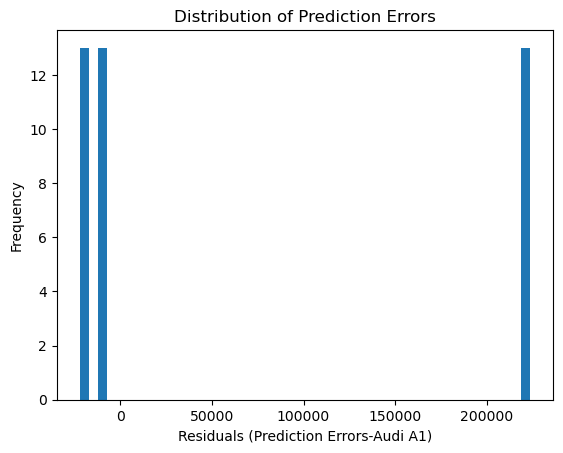

In [85]:
# Plot histogram of residuals
plt.hist(final_comparison_df['Residuals'].loc[final_comparison_df['model']=='Audi A1'], bins=50)
plt.xlabel('Residuals (Prediction Errors-Audi A1)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

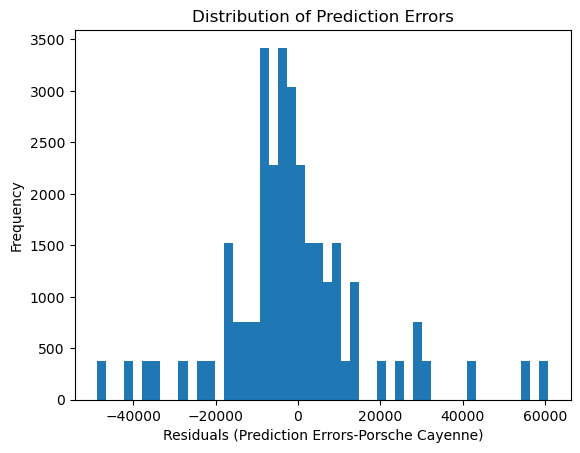

In [86]:
# Plot histogram of residuals
plt.hist(final_comparison_df['Residuals'].loc[final_comparison_df['model']=='Porsche Cayenne'], bins=50)
plt.xlabel('Residuals (Prediction Errors-Porsche Cayenne)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()